In [15]:
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.interpolate as scint
import numpy as np
import time
import tqdm as tqdm
from custom_layer import ScaleAngles
import os

# replace the argparse / sys.argv code with a notebook-relative path
nb_dir = os.getcwd()   # notebook working directory (where the .ipynb is opened)
infile = os.path.join(nb_dir, "models", "2026-01-25_model1_s0.9.keras")

# ensure expansion and show status for debugging
infile = os.path.expanduser(infile)
print("Using model file:", infile, "exists:", os.path.exists(infile))


Using model file: /Users/danny/Documents/Courses/Year 4/Code/mldirc/dense/dualfilm/models/2026-01-25_model1_s0.9.keras exists: True


In [16]:
datafrac = 1
indata  = np.load('500K22TO140dualfilm_lowbins.npz', mmap_mode='r')
TIMES   = indata['TIMES']; HISTS = indata['HISTS']; MOM = indata['ANGLES']; LABELS = indata['LABELS']
nevents = TIMES.shape[0]

TIMES   = TIMES[int(nevents*(1-datafrac)):]
HISTS   = HISTS[int(nevents*(1-datafrac)):]
MOM     = MOM[int(nevents*(1-datafrac)):]
LABELS  = LABELS[int(nevents*(1-datafrac)):]

theta = np.arccos(MOM.T[6])*180/np.pi

In [17]:
model = keras.models.load_model(infile)

t1 = time.time()
# Make predictions on dataset
predictions = model.predict((TIMES, HISTS, MOM), verbose=0)
pred_labels = np.argmax(predictions, axis=1)

t2 = time.time()

print(f'[INFO] Evaluated {nevents} events in {t2-t1} seconds;\n{((t2-t1)/nevents) * 10**6} µs per event')


[INFO] Evaluated 455040 events in 47.54242706298828 seconds;
104.4796656623336 µs per event


MODEL INSPECTION

Output Layer: output
Output dtype: float32
Optimizer: <keras.src.optimizers.adam.Adam object at 0x17ab1d8b0>

Predictions dtype: bfloat16
Sample predictions (first 5):
[[0.5 0.5]
 [0.5 0.5]
 [0.119629 0.882812]
 [0.5 0.5]
 [0.267578 0.730469]]

Number of unique confidence values: 14
Confidence range: [0.5, 1]
Minimum step between unique values: 0.0078125
Quantization bits (estimated): 7 bits


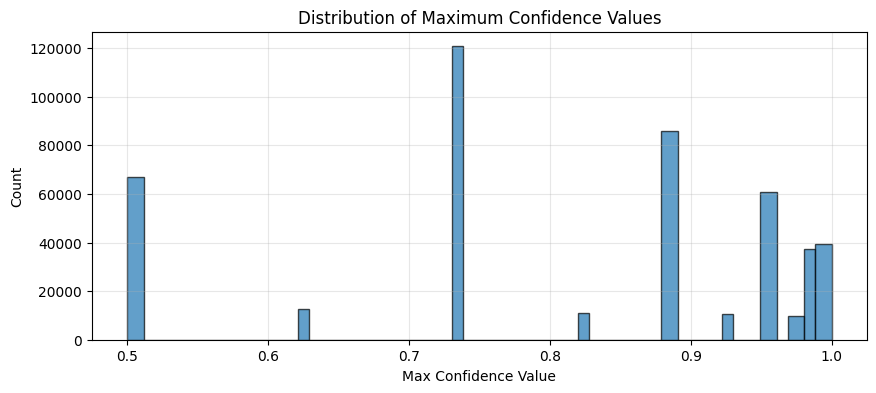


First 20 unique confidence values:
[0.5 0.621094 0.730469 0.777344 0.820312 0.851562 0.882812 0.902344
 0.925781 0.957031 0.96875 0.984375 0.992188 1]


In [18]:
# Diagnose model quantization and precision
print("=" * 60)
print("MODEL INSPECTION")
print("=" * 60)

# Check output layer properties
output_layer = model.layers[-1]
print(f"\nOutput Layer: {output_layer.name}")
print(f"Output dtype: {output_layer.dtype}")

# Check for quantization in layer config
if hasattr(model, 'optimizer'):
    print(f"Optimizer: {model.optimizer}")

# Inspect prediction precision
print(f"\nPredictions dtype: {predictions.dtype}")
print(f"Sample predictions (first 5):\n{predictions[:5]}")

# Check unique confidence values and their distribution
max_confidences = np.max(predictions, axis=1)
unique_confidences = np.unique(max_confidences)
print(f"\nNumber of unique confidence values: {len(unique_confidences)}")
print(f"Confidence range: [{float(max_confidences.min())}, {max_confidences.max()}]")

# Compute the quantization step size
if len(unique_confidences) > 1:
    sorted_unique = np.sort(unique_confidences)
    diffs = np.diff(sorted_unique)
    min_step = np.min(diffs[diffs > 0])
    print(f"Minimum step between unique values: {min_step}")
    print(f"Quantization bits (estimated): {-np.log2(min_step)} bits")

# Show histogram of confidence values
plt.figure(figsize=(10, 4))
plt.hist(max_confidences, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Max Confidence Value')
plt.ylabel('Count')
plt.title('Distribution of Maximum Confidence Values')
plt.grid(True, alpha=0.3)
plt.show()

# First 20 unique values
print(f"\nFirst 20 unique confidence values:\n{sorted_unique[:20]}")


In [19]:
# Analyze the 14 unique values in detail
print("\n" + "=" * 60)
print("DETAILED ANALYSIS OF 14 UNIQUE VALUES")
print("=" * 60)

sorted_unique = np.sort(unique_confidences)
print(f"\nAll {len(sorted_unique)} unique confidence values:")
for i, val in enumerate(sorted_unique):
    count = np.sum(max_confidences == val)
    print(f"  {i+1}. {val}  (appears {count} times)")

# Check if they're fractions of 256 or other common quantization patterns
print("\nChecking for quantization patterns:")
print(f"Values * 256 (int8 check):")
for val in sorted_unique:
    print(f"  {val} * 256 = {val * 256}")

print(f"\nValues * 16384 (int14 check):")
for val in sorted_unique:
    print(f"  {val} * 16384 = {val * 16384}")

# Check step sizes between consecutive values
diffs = np.diff(sorted_unique)
print(f"\nStep sizes between consecutive values:")
for i, diff in enumerate(diffs):
    print(f"  {sorted_unique[i]} -> {sorted_unique[i+1]}: {diff}")



DETAILED ANALYSIS OF 14 UNIQUE VALUES

All 14 unique confidence values:
  1. 0.5  (appears 67073 times)
  2. 0.621094  (appears 12524 times)
  3. 0.730469  (appears 120721 times)
  4. 0.777344  (appears 1 times)
  5. 0.820312  (appears 11000 times)
  6. 0.851562  (appears 2 times)
  7. 0.882812  (appears 86065 times)
  8. 0.902344  (appears 1 times)
  9. 0.925781  (appears 10688 times)
  10. 0.957031  (appears 60768 times)
  11. 0.96875  (appears 9649 times)
  12. 0.984375  (appears 37251 times)
  13. 0.992188  (appears 27306 times)
  14. 1  (appears 11991 times)

Checking for quantization patterns:
Values * 256 (int8 check):
  0.5 * 256 = 128
  0.621094 * 256 = 159
  0.730469 * 256 = 187
  0.777344 * 256 = 199
  0.820312 * 256 = 210
  0.851562 * 256 = 218
  0.882812 * 256 = 226
  0.902344 * 256 = 231
  0.925781 * 256 = 237
  0.957031 * 256 = 245
  0.96875 * 256 = 248
  0.984375 * 256 = 252
  0.992188 * 256 = 254
  1 * 256 = 256

Values * 16384 (int14 check):
  0.5 * 16384 = 8192
  0.

In [20]:
# Identify the quantization scheme
print("\n" + "=" * 60)
print("QUANTIZATION SCHEME IDENTIFICATION")
print("=" * 60)

# The values * 256 are clean integers - this is int8!
int8_values = np.round(sorted_unique * 256).astype(int)
print(f"\nValues as int8 (0-256 range):")
print(int8_values)

print(f"\nThis is INT8 QUANTIZATION - the model outputs are 8-bit integers")
print(f"scaled to the range [0.5, 1.0]")

# Show which int8 values are actually used
all_possible = np.arange(128, 257)  # 0.5 to 1.0 in int8
used_values = set(int8_values)
unused = sorted(set(all_possible) - used_values)

print(f"\nOut of {len(all_possible)} possible int8 values from 0.5 to 1.0:")
print(f"  Only {len(used_values)} are actually used in predictions")
print(f"  {len(unused)} unused values: {unused}")

# Check model config for quantization info
print(f"\nModel config analysis:")
model_config = model.get_config()
if 'quantization_config' in model_config:
    print(f"  Quantization config found: {model_config['quantization_config']}")
else:
    print(f"  No explicit quantization_config in model")

# Check if there's any metadata about quantization
for layer in model.layers:
    if hasattr(layer, 'quantization_config'):
        print(f"  Layer {layer.name} has quantization_config")



QUANTIZATION SCHEME IDENTIFICATION

Values as int8 (0-256 range):
[128 159 187 199 210 218 226 231 237 245 248 252 254 256]

This is INT8 QUANTIZATION - the model outputs are 8-bit integers
scaled to the range [0.5, 1.0]

Out of 129 possible int8 values from 0.5 to 1.0:
  Only 14 are actually used in predictions
  115 unused values: [np.int64(129), np.int64(130), np.int64(131), np.int64(132), np.int64(133), np.int64(134), np.int64(135), np.int64(136), np.int64(137), np.int64(138), np.int64(139), np.int64(140), np.int64(141), np.int64(142), np.int64(143), np.int64(144), np.int64(145), np.int64(146), np.int64(147), np.int64(148), np.int64(149), np.int64(150), np.int64(151), np.int64(152), np.int64(153), np.int64(154), np.int64(155), np.int64(156), np.int64(157), np.int64(158), np.int64(160), np.int64(161), np.int64(162), np.int64(163), np.int64(164), np.int64(165), np.int64(166), np.int64(167), np.int64(168), np.int64(169), np.int64(170), np.int64(171), np.int64(172), np.int64(173), np.

In [ ]:
confidences = 1 - np.linspace(0.5, 0.997, 100)
accuracies = []


for confidence in tqdm.tqdm(confidences, total=len(confidences), desc='Calculating accuracy vs confidence'):
    correct     = 0
    total       = 0
    for i, pred in enumerate(predictions):
        if pred[np.argmax(pred)] >= 1 - confidence:
            total += 1
            if np.argmax(pred) == LABELS[i]:
                correct += 1
    
    accuracies.append(correct/total if total else 0)


Calculating accuracy vs confidence:  36%|███▌      | 36/100 [02:34<02:45,  2.58s/it]

In [ ]:
confidence  = 0.008
correct     = 0
total       = 0

print(predictions)

for i, pred in enumerate(predictions):
    if pred[np.argmax(pred)] >= 1 - confidence:
        total += 1
        if np.argmax(pred) == LABELS[i]:
            correct += 1
            
try:
    print(f'Accuracy: {correct} out of {total}... {correct/total:0.5f}\nEvents Kept: {total} out of {predictions.shape[0]}... {total/predictions.shape[0]:0.5f}')
except ZeroDivisionError:
    print('No events kept!')

[[0.730469 0.267578]
 [0.267578 0.730469]
 [0.267578 0.730469]
 ...
 [0.5 0.5]
 [0.5 0.5]
 [0.0180664 0.984375]]
Accuracy: 44052 out of 44858... 0.98203
Events Kept: 44858 out of 455040... 0.09858


100 100


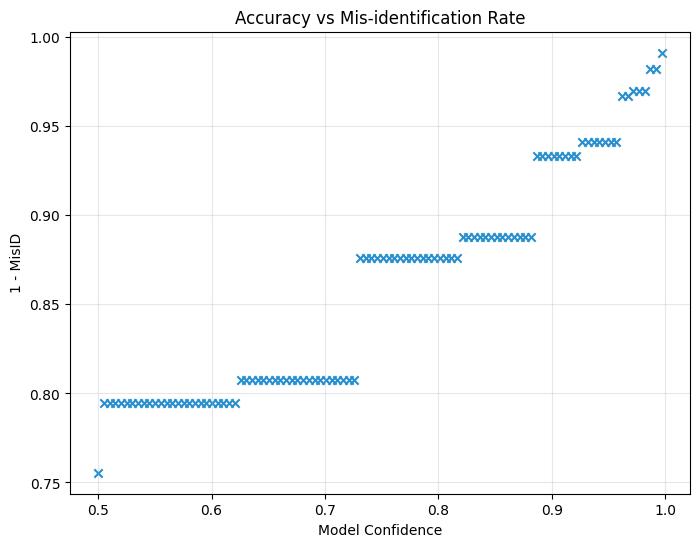

In [ ]:
print(len(accuracies), len(confidences))

mis_id = 1 - np.array(accuracies)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(1 - confidences, accuracies, marker='x', c="#288ECE")
ax.set_xlabel('Model Confidence')
ax.set_ylabel('1 - MisID')
ax.set_title('Confidence vs Mis-identification Rate')
ax.grid(True, which='both', alpha=0.3)

plt.show()